# ENGINE



In [3]:
import warnings
warnings.filterwarnings("ignore")


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam


In [5]:
df = pd.read_csv("dump_truck_engine_anomaly_dataset.csv")

df.head()


,engine_temperature_C,oil_pressure_bar,engine_rpm,fuel_consumption_lph,vibration_mm_s,label
0,92.483571,4.870471,2079.871087,38.113444,2.162411,0
1,89.308678,5.263767,1984.926737,32.795257,2.427741,0
2,93.238443,3.940573,1811.926074,31.727204,2.103790,0
3,97.615149,4.725188,1670.612644,34.986502,2.346019,0
4,88.829233,4.239743,1939.644663,34.319262,1.553193,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   engine_temperature_C  500 non-null    float64
 1   oil_pressure_bar      500 non-null    float64
 2   engine_rpm            500 non-null    float64
 3   fuel_consumption_lph  500 non-null    float64
 4   vibration_mm_s        500 non-null    float64
 5   label                 500 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 23.6 KB


In [7]:
X = df.drop(columns=["label"])
y = df["label"]   # Used only for evaluation


In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [9]:
X_train = X_scaled[y == 0]   # Only normal samples


In [10]:
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim,))

encoder = Dense(8, activation="relu")(input_layer)
encoder = Dense(4, activation="relu")(encoder)

decoder = Dense(8, activation="relu")(encoder)
decoder = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse"
)

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 169 (676.00 B)

 Trainable params: 169 (676.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = autoencoder.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    shuffle=True
)


In [12]:
X_pred = autoencoder.predict(X_scaled)

reconstruction_error = np.mean(np.square(X_scaled - X_pred), axis=1)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [13]:
threshold = np.percentile(reconstruction_error, 90)
print("Anomaly Threshold:", threshold)


Anomaly Threshold: 1.1474721337732228


In [14]:
df["reconstruction_error"] = reconstruction_error
df["predicted_label"] = (reconstruction_error > threshold).astype(int)

df.head()


,engine_temperature_C,oil_pressure_bar,engine_rpm,fuel_consumption_lph,vibration_mm_s,label,reconstruction_error,predicted_label
0,92.483571,4.870471,2079.871087,38.113444,2.162411,0,0.023907,0
1,89.308678,5.263767,1984.926737,32.795257,2.427741,0,0.154651,0
2,93.238443,3.940573,1811.926074,31.727204,2.103790,0,0.213415,0
3,97.615149,4.725188,1670.612644,34.986502,2.346019,0,0.186128,0
4,88.829233,4.239743,1939.644663,34.319262,1.553193,0,0.100578,0


In [15]:
print(classification_report(y, df["predicted_label"]))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       450
           1       1.00      1.00      1.00        50

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



In [16]:
confusion_matrix(y, df["predicted_label"])


array([[450,   0],
       [  0,  50]])

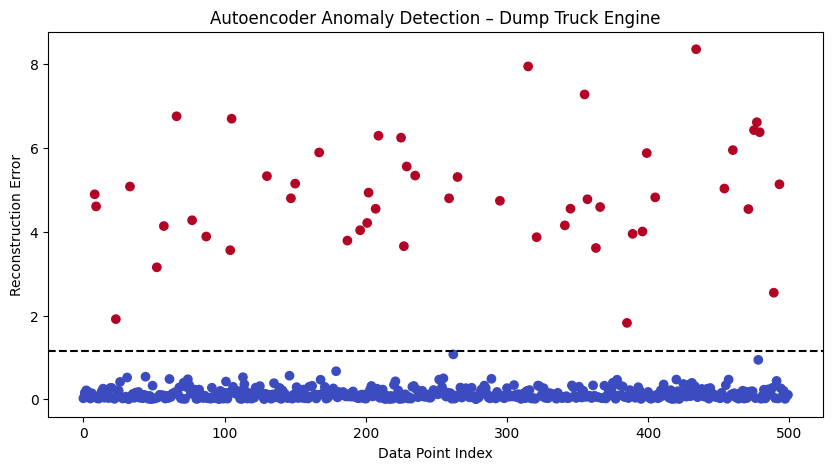

In [17]:
plt.figure(figsize=(10,5))
plt.scatter(range(len(reconstruction_error)), reconstruction_error,
            c=df["predicted_label"], cmap="coolwarm")
plt.axhline(threshold, color="black", linestyle="--")
plt.xlabel("Data Point Index")
plt.ylabel("Reconstruction Error")
plt.title("Autoencoder Anomaly Detection – Dump Truck Engine")
plt.show()


In [19]:
df.loc[df["label"] == 1].assign(Row_Number=df.index[df["label"] == 1] + 1)


,engine_temperature_C,oil_pressure_bar,engine_rpm,fuel_consumption_lph,vibration_mm_s,label,reconstruction_error,predicted_label,Row_Number
8,121.166111,2.561949,2009.910543,35.353628,6.126895,1,4.894616,1,9
9,111.884442,2.147372,1692.952958,40.910120,5.415653,1,4.605931,1,10
23,107.502538,3.083405,2228.454072,31.162243,4.640897,1,1.914226,1,24
33,101.200379,2.163062,1929.439188,34.409590,8.343754,1,5.080240,1,34
52,116.021307,3.354571,1898.806037,31.488070,6.192222,1,3.151250,1,53
57,112.703417,2.541491,2034.545804,31.787284,6.939041,1,4.135902,1,58
66,120.287317,1.889467,1541.063705,35.267963,6.034675,1,6.756731,1,67
77,117.411774,3.107161,1714.376968,39.658957,6.208449,1,4.275068,1,78
87,115.278144,2.356921,1847.757832,33.531889,5.253849,1,3.886341,1,88
104,112.285951,3.035355,2021.636563,33.069026,7.076956,1,3.559641,1,105
